# **Health Care Dataset**

<div style="text-align: justify; font-weight: bold;">
<i>Abstract</i> — In this computer assignment, we want to perform statistical analysis on healthCare dataset. We will use methods that we learnt in Statistical Inference. Also, we will use R programming language to reach this goal.
    
<i>Keywords</i> — Statistical Inference, R
 </div>

### **Importing Libraries**


In this part, we will import some of the necessary libraries in order to use their helpful functions. Firstly, we will install related packages. Secondly, we will use `library()` function to import them.

In [ ]:
options(warn=-1)
install.packages("plyr")
install.packages("GGally")
install.packages("caret")
install.packages("ggcorrplot")

In [ ]:
library(plyr)
library(ggplot2)
library(GGally)
library(caret)
library(ggcorrplot)
library(pROC)

### __Importing Data__
In this part, file *HealthCare.csv* is coppied to the project directory, then we read and store it in a dataframe called *heathCare*.

In [ ]:
healthCare <- read.csv("/content/HealthCare.csv")

In [ ]:
summary(healthCare)

       id           gender               age         hypertension    
 Min.   :   67   Length:5110        Min.   : 0.08   Min.   :0.00000  
 1st Qu.:17741   Class :character   1st Qu.:25.00   1st Qu.:0.00000  
 Median :36932   Mode  :character   Median :45.00   Median :0.00000  
 Mean   :36518                      Mean   :43.23   Mean   :0.09746  
 3rd Qu.:54682                      3rd Qu.:61.00   3rd Qu.:0.00000  
 Max.   :72940                      Max.   :82.00   Max.   :1.00000  
                                                                     
 heart_disease     ever_married        work_type         Residence_type    
 Min.   :0.00000   Length:5110        Length:5110        Length:5110       
 1st Qu.:0.00000   Class :character   Class :character   Class :character  
 Median :0.00000   Mode  :character   Mode  :character   Mode  :character  
 Mean   :0.05401                                                           
 3rd Qu.:0.00000                                            

### __Cleaning Data__
In this part, we will convert the column values that are in a wrong format to an appropriate format. Values in **hypertension**, **heart_disease**, and **stroke** are stored as Integer but they categorical variables and it would be better to store them as String. This can be done by using `mapvalues()` method from *plyr* library.

In [ ]:
healthCare$hypertension <- mapvalues(healthCare$hypertension,
                           from = c(0, 1),
                           to = c("No", "Yes"))

In [ ]:
healthCare[(healthCare$gender=="Other"),]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,health_bills
,<int>,<chr>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>
3117,56156,Other,26,No,0,No,Private,Rural,143.33,22.4,formerly smoked,0,2241.059


In [ ]:
healthCare <- healthCare[!(healthCare$gender=="Other"),]

### __Handling NA Values__
In this part, we will use a combination of `colMeans()` and `is.na()` methods in order to compute proportion of nan values in each column.

In [ ]:
colMeans(is.na(healthCare))

id            gender               age      hypertension 
       0.00000000        0.00000000        0.00000000        0.00000000 
    heart_disease      ever_married         work_type    Residence_type 
       0.00000000        0.00000000        0.00000000        0.00000000 
avg_glucose_level               bmi    smoking_status            stroke 
       0.00000000        0.03934234        0.00000000        0.00000000 
     health_bills 
       0.03934234

Based on the result, **bmi** and **health_bills** have about 4% nan values. 

One of the methods to deal with these value is to replace them with a statistic of that column.

For **bmi** we will use mean to replace missing values, because it has an aproximately normal distribution as its median and mean are close to each other. 

In [ ]:
healthCare[c("bmi")][is.na(healthCare[c("bmi")])] <- mean(healthCare$bmi, na.rm=TRUE)

For **health_bills** it seems that median can be a better statistic to replace nan values with. 

In [ ]:
healthCare[c("health_bills")][is.na(healthCare[
  c("health_bills")])] <- median(healthCare$health_bills, na.rm=TRUE)

### __Question 1__
In this question, we have to choose two categorical feature with more than two levels. Based on our dataset, only **Work Type** and **Smoking Status** satisfy this criteria. So, we choose them to do following tasks.

Before doing next parts, let take a look on the levels of these two features.

1.   **work type**
          
        It defines the type of work a person does.
        *   Private
        *   Self-employed
        *   Govt_job
        *   children
        *   Never_worked


2.  **smoking status**
          
      It is the person smoking status. 
      *   formerly smoked
      *   never smoked
      *   smokes
      *   Unknown

#### __Part A__
In this part, we have two choose a level from each feature to be able to compare their proportion by the methods that we have learnt so far. We choose **Govt_job** from **Work Type** and **smokes** from **Smoking Status**. We will take a sample for each categorical variable.

Firstly, we have to check conditions for inference:


**Independence**


*   **within groups**
    
    Based on the documentation, data is gathered using random sampling technique.

    Sampling method that is used is without replacement. But, 300 (sample size) is less than 10 percent of population (500). Therefore, this condition is met.
*   **between groups** 

    Two groups must be independent of each other (non-paired). We will take samples without replacement to satisfy this condition.

**Sample size/skew**

We should at least 10 successes and 10 failures for each group. Now we can check this condition.






In [ ]:
n1 <- 300
n2 <- 300
set.seed(123)
smokeRows <- sample(nrow(healthCare), n1)
smokeSample <- healthCare[smokeRows,]

workRows <- sample(nrow(healthCare[-smokeRows,]), n2)
workSample <- healthCare[workRows,]

In [ ]:
p1 <- sum(smokeSample$smoking_status == "smokes") / n1
p2 <- sum(workSample$work_type == "Govt_job") / n2

In [ ]:
(n1 * (1 - p1) >= 10 && n1 * p1 >= 10)

[1] TRUE

In [ ]:
(n2 * (1 - p2) >= 10 && n2 * p2 >= 10)

[1] TRUE

Based on the result, sample size/skew condition is satisfied.

Now it is time to compute confidence interval for the difference between proportion of these two groups. At first, we have to compute standard error for the difference.

$$SE_{(\hat{p_1}-\hat{p_2})}=\sqrt{\frac{\hat{p_1}(1-\hat{p_1})}{n_1} + \frac{\hat{p_2}(1-\hat{p_2})}{n_2}}$$



In [ ]:
SE <- sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
SE

[1] 0.02899489

The formula for calculating confidence interval is as follows:
$$(\hat{p_1}-\hat{p_2}) \pm z^{*}SE_{(\hat{p_1}-\hat{p_2})}$$

In [ ]:
diff <- p1 - p2

CI = 0.95
zStar <- qnorm((1 - CI) / 2, lower.tail = FALSE)
ME <- SE * zStar

low <- diff - ME
up <- diff + ME

print(paste("the 95% CI=(",low,"up to ",up,")"), quote = FALSE)

[1] the 95% CI=( -0.0268289420822068 up to  0.0868289420822068 )


We are 95% confident that the difference in the population proportion of individuals who have never work and the population proportion of individuals who smoke lies between -0.027 and 0.087.

#### __Part B__
In this part, we use chi-square test to check whether these groups are independent or not.

Let's check the conditions for this test.

**Independence**


*  The sampling technique based on the documentation is random.
*  The sample size is 300 which is less than 10 percent of the population.
*   Each case only contributes to one cell in the table.


**Sample size**

Each cell must have at least 5 expected cases. We can check this condition by constructing contingency table.


In [ ]:
smokingVsWorkType <- table(smokeSample$smoking_status, workSample$work_type)
smokingVsWorkType

                 
                  children Govt_job Private Self-employed
  formerly smoked        5        9      33            14
  never smoked          21        9      55            18
  smokes                 5       13      24             7
  Unknown               12        9      52            14

In [ ]:
chisq.test(smokingVsWorkType)$expected

,children,Govt_job,Private,Self-employed
formerly smoked,8.743333,8.133333,33.34667,10.776667
never smoked,14.763333,13.733333,56.30667,18.196667
smokes,7.023333,6.533333,26.78667,8.656667
Unknown,12.470000,11.600000,47.56000,15.370000


Based on the result, the value of each cell is at least 5. Therefore sample size condition for the test is met.

Now it is time to state our hypothesis for independence test.

$$H_0 (\textrm{nothing going on}):\textrm{Work type and smoking status are independent.}$$
$$H_A (\textrm{something going on}):\textrm{Work type and smoking status are dependent.}$$

In [ ]:
chisq.test(smokingVsWorkType)


	Pearson's Chi-squared test

data:  smokingVsWorkType
X-squared = 15.689, df = 9, p-value = 0.07367


$$p-value = 0.07367 > 0.05 \implies$$

Since p-value is greater than 0.05, we fail to reject null hypothesis. The data do not provide convincing evidence that work type and smoking status are dependent. 

### __Question 2__
In this question, we have to choose a binary categorical feature. Based on our dataset, one of the variables that satisfies this condition is **Ever Married**. Its levels are *Yes* and *No*. We consider *Yes* as success in this context.

Firstly, we take a random sample of size 12 from our data and keep the target column.

In [ ]:
set.seed(123)
sampleSize <- 12
rows <- sample(1:nrow(healthCare), sampleSize)
smallSample <- healthCare[rows, ]["ever_married"]
pObserved <- sum(smallSample$ever_married == "Yes") / sampleSize
pObserved

[1] 0.5833333

$$H_0: p = 0.5$$
$$H_A: p \gt 0.5$$

**Independence**


*  The sampling technique is random.
*  The sample size is 12 which is less than 10 percent of the population.


**Sample size / skew**

12 × 0.5 = 6 → not met

distribution of sample proportions cannot be assumed to be 
nearly normal

Now we will take 3000 random samples from data and run our simulation to compute the p-value.

In [ ]:
set.seed(123)
simCount <- 3000
nullSample <- c(rep(1, 6), rep(0, 6))
simSamples <- replicate(simCount, sample(nullSample, size = sampleSize, replace = TRUE))
proportions <- colSums(simSamples) / sampleSize
pValue <- sum(proportions >= pObserved) / simCount
pValue

[1] 0.384

$$p-value = 0.384 > 0.05 \implies$$

We fail to reject null hypothesis. Results from the simulations look like the data → the proportion of ever married was due to chance.

### __Question 3__

#### __Part A__
In this part, we choose **Smoking Status** as a categorical variable which has 4 levels.

  *   formerly smoked
  *   never smoked
  *   smokes
  *   Unknown

Now we use `table()` method to get frequency of each level in dataset. Then, we divide it by n to get the probability distribution of this variable.

In [ ]:
n <- length(healthCare$smoking_status)
smokingDist <- table(healthCare$smoking_status) / n
smokingDist


formerly smoked    never smoked          smokes         Unknown 
      0.1730280       0.3703269       0.1544334       0.3022118 

Bsed on the result we can see the probability distribution of **Smoking Status** in the whole dataset. The probability of each possible outcome is specified.

In this part, we have to compare the probability distribution of each sample with the original dataset. As a result, we should perform ***Goodness of Fit*** test. At first, we must check the conditions for this test.

**Independence**


*  The sampling technique is random. (with or without bias)
*  The sample size is 100 which is less than 10 percent of the population.
*   Each case only contributes to one cell in the table.


**Sample size**

Each cell must have at least 5 expected cases. We can check this condition by constructing contingency table.

**Random Sample**

In this part, we randomly select 100 data point from our dataset.We have to select indices of these data points using `sample()` function. Then we will filter dataset by these indices and **Smoking Status** feature.


In [ ]:
sampleSize <- 100
set.seed(123)
randomRows <- sample(nrow(healthCare), sampleSize)
randomSample <- healthCare[randomRows,]["smoking_status"]

Here, by calling `table()` function on random sample we can see its frequency table. 

In [ ]:
randomDist <- table(randomSample$smoking_status)
randomDist


formerly smoked    never smoked          smokes         Unknown 
             21              31              16              32 

The value in each cell is greater than 5. So, the sample size condition is met. 

Now it is time to state our hypothesis for independence test.

$$H_0 (\textrm{nothing going on}):\textrm{The random sample follows the same smoking status distribution in the population.}$$
$$H_A (\textrm{something going on}):\textrm{The random sample does not follow the same smoking status distribution in the population.}$$


Let's perform our test by calling `chisq.test()` function on the random sample distribution and original distribution as probability.

In [ ]:
chisq.test(randomDist, p=smokingDist)


	Chi-squared test for given probabilities

data:  randomDist
X-squared = 1.8975, df = 3, p-value = 0.5939


$$p-value = 0.5939 > 0.05 \implies$$

We fail to reject null hypothesis. The data do not provide convincing evidence that the random sample distribution differs from the original distribution.

**Biased Sample**

In this part, we will make our biased sample. For this goal, we select data point in a way that **never smoked** users have more chance to be in our sample.

In [ ]:
set.seed(123)
prob <- ifelse(healthCare$smoking_status=="never smoked", 0.7, 0.3)
biasedRows <- sample(nrow(healthCare), sampleSize, prob = prob)
biasedSample <- healthCare[biasedRows,]["smoking_status"]

In this part we will repreat the steps that we we have done for random sample.

In [ ]:
biasedDist <- table(biasedSample$smoking_status)
biasedDist


formerly smoked    never smoked          smokes         Unknown 
             14              59              11              16 

The value in each cell is greater than 5. So, the sample size condition is met. 

Now it is time to state our hypothesis for independence test.

$$H_0 (\textrm{nothing going on}):\textrm{The biased sample follows the same smoking status distribution in the population.}$$
$$H_A (\textrm{something going on}):\textrm{The biased sample does not follow the same smoking status distribution in the population.}$$

In [ ]:
chisq.test(biasedDist, p=smokingDist)


	Chi-squared test for given probabilities

data:  biasedDist
X-squared = 21.632, df = 3, p-value = 7.782e-05


$$p-value = 7.782e-05 < 0.05 \implies$$

We reject null hypothesis. The data provide convincing evidence that the biased sample distribution differs from the original distribution.

#### __Part B__
In this part, we choose **Ever married** as the second categorical variable. We use chi-square test to check whether these groups are independent or not.

We take two non-paired samples of size 200 for our test to meet independence condition.

In [ ]:
nSmoking <- 200
nMarriage <- 200
set.seed(123)
smokingRows <- sample(nrow(healthCare), nSmoking)
smokingSample <- healthCare[smokingRows,]

marriageRows <- sample(nrow(healthCare[-smokingRows,]), nMarriage)
marriageSample <- healthCare[marriageRows,]

Let's check the conditions for this test.

**Independence**


*  The sampling technique based on the documentation is random.
*  The sample size is 200 which is less than 10 percent of the population.
*   Each case only contributes to one cell in the table.


**Sample size**

Each cell must have at least 5 expected cases. We can check this condition by constructing contingency table.


In [ ]:
marriageVsSmoking <- table(marriageSample$ever_married, smokingSample$smoking_status)
marriageVsSmoking

     
      formerly smoked never smoked smokes Unknown
  No               17           30      8      21
  Yes              26           38     23      37

In [ ]:
chisq.test(marriageVsSmoking)$expected

,formerly smoked,never smoked,smokes,Unknown
No,16.34,25.84,11.78,22.04
Yes,26.66,42.16,19.22,35.96


Based on the result, the value of each cell is at least 5. Therefore sample size condition for the test is met.

Now it is time to state our hypothesis for independence test.

$$H_0 (\textrm{nothing going on}):\textrm{Ever married and smoking status are independent.}$$
$$H_A (\textrm{something going on}):\textrm{Ever married and smoking status are dependent.}$$

In [ ]:
chisq.test(marriageVsSmoking)


	Pearson's Chi-squared test

data:  marriageVsSmoking
X-squared = 3.1587, df = 3, p-value = 0.3678


$$p-value = 0.3678 > 0.05 \implies$$

Since p-value is greater than 0.05, we fail to reject null hypothesis. The data do not provide convincing evidence that ever married and smoking status are dependent. 

### __Question 4__

In this question, I select **Health Bills** as a response variable, because I believe that this is one of the important factors in our financial decisions.

I select **BMI** and **Age** as exaplanatory variables for our model. Based on the results of *Phase 1* we concluded that there is an association between **BMI** and our response variable. Moreover, it is undeniable that the older we get, the more health bills we should pay.



#### __Part A__
In *Phase 1* we saw that **BMI** is the most associated feature with our response variable in our dataset. As a result, I guess that it would be better predictor in our model.

#### __Part B__
In this part, we will discuss questions a to b for *BMI* and *Age* respectively.

##### __BMI__


###### __a__
**Least Squares Regression**

In this question, we use `lm()` method in order to compute linear regression model for the response variable using *BMI* as the only explanatory variable.

In [ ]:
bmiModel <- lm(health_bills ~ bmi, data = healthCare)
summary(bmiModel)


Call:
lm(formula = health_bills ~ bmi, data = healthCare)

Residuals:
    Min      1Q  Median      3Q     Max 
-3232.0  -429.8  -102.3   258.3  5872.5 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1852.434     39.838   46.50   <2e-16 ***
bmi           44.373      1.332   33.31   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 733 on 5107 degrees of freedom
Multiple R-squared:  0.1785,	Adjusted R-squared:  0.1783 
F-statistic:  1109 on 1 and 5107 DF,  p-value: < 2.2e-16


Based on the result, p-value for this predictor is about 0 that is less than 0.05. Therefore we can conclude that it is a good predictor for the response variable.

###### __b__
**Predictive Equation**

The predictive equation for this linear model is as follows:

$$healthBills=1856.626+44.373×bmi$$

**Intercept**

When *BMI = 0*, *Health Bills* is expected to equal 1856.626. In this model, having bmi = 0 is somehow meaningless.

**Slope**

For each unit increase in *BMI*, *Health Bills* is expected to be higher on average by 44.373.

###### __c__
**Scatter Plot**

In this question, we use `geom_point()` method to show data points in our scatter plot. Moreover, we use `stat_smooth()` method to draw the least-squares fit that we obtained in a and b.

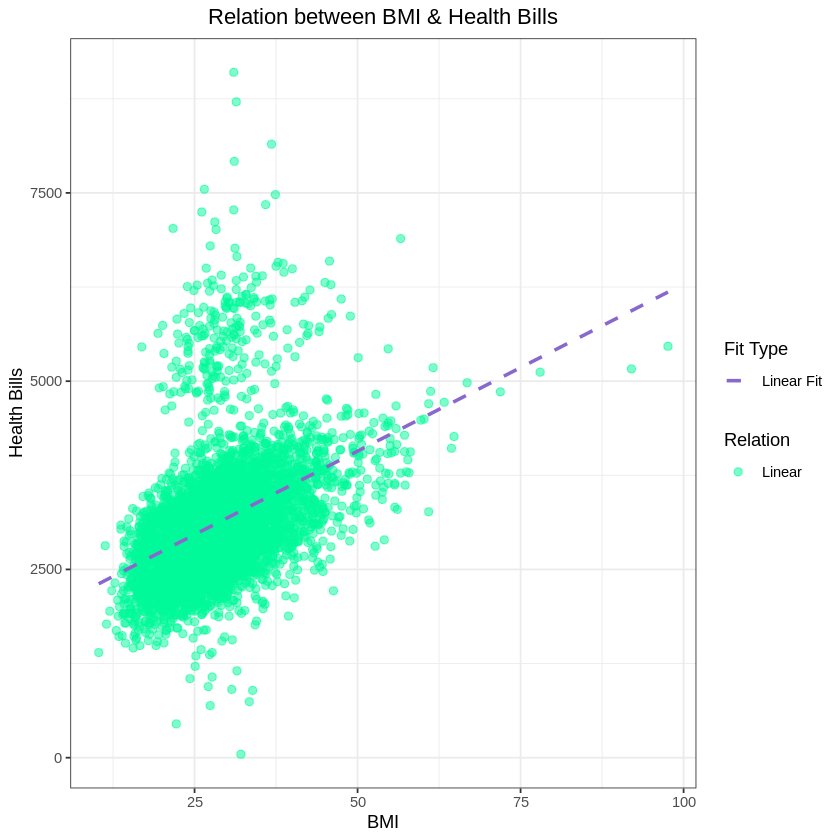

In [ ]:
bmiScatter <- ggplot(healthCare, aes(x = bmi))
bmiScatter <- bmiScatter + geom_point(aes(y = health_bills, color = "Linear"), size = 2, alpha = 0.5)
bmiScatter <- bmiScatter + stat_smooth(aes(x = bmi, y = health_bills, linetype = "Linear Fit"),
              method = "lm", formula = y ~ x, se = F, color = "mediumpurple3") 
bmiScatter <- bmiScatter + scale_color_manual(name = "Relation", values = c("mediumspringgreen", "thistle1")) 
bmiScatter <- bmiScatter + scale_linetype_manual(name = "Fit Type", values = c(2, 2)) 
bmiScatter <- bmiScatter + xlab("BMI")
bmiScatter <- bmiScatter + ylab("Health Bills")
bmiScatter <- bmiScatter + ggtitle("Relation between BMI & Health Bills")
bmiScatter <- bmiScatter + theme_bw()
bmiScatter <- bmiScatter + theme(plot.title = element_text(hjust = 0.5))
bmiScatter

##### __Age__


###### __a__
**Least Squares Regression**

In this question, we use the same code as what we explained for *BMI* to reach the linear model for this new predictor.

In [ ]:
ageModel <- lm(health_bills ~ age, data = healthCare)
summary(ageModel)


Call:
lm(formula = health_bills ~ age, data = healthCare)

Residuals:
    Min      1Q  Median      3Q     Max 
-3213.6  -465.1   -90.5   338.2  5589.6 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2679.7026    23.3308   114.9   <2e-16 ***
age           10.5222     0.4782    22.0   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 772.9 on 5107 degrees of freedom
Multiple R-squared:  0.08659,	Adjusted R-squared:  0.08641 
F-statistic: 484.1 on 1 and 5107 DF,  p-value: < 2.2e-16


Based on the result, p-value for this predictor is about 0 that is less than 0.05. Therefore we can conclude that it is a good predictor for the response variable.

###### __b__
**Predictive Equation**

The predictive equation for this linear model is as follows:

$$healthBills=2663.58+11.0847×age$$

**Intercept**

When *Age = 0*, *Health Bills* is expected to equal 2663.58. 
**Slope**

For each unit increase in *Age*, *Health Bills* is expected to be higher on average by 11.0847.

###### __c__
**Scatter Plot**

In this question, again we use the same code as what we explained for *BMI* to draw scatter plot and fit line for the linear model.

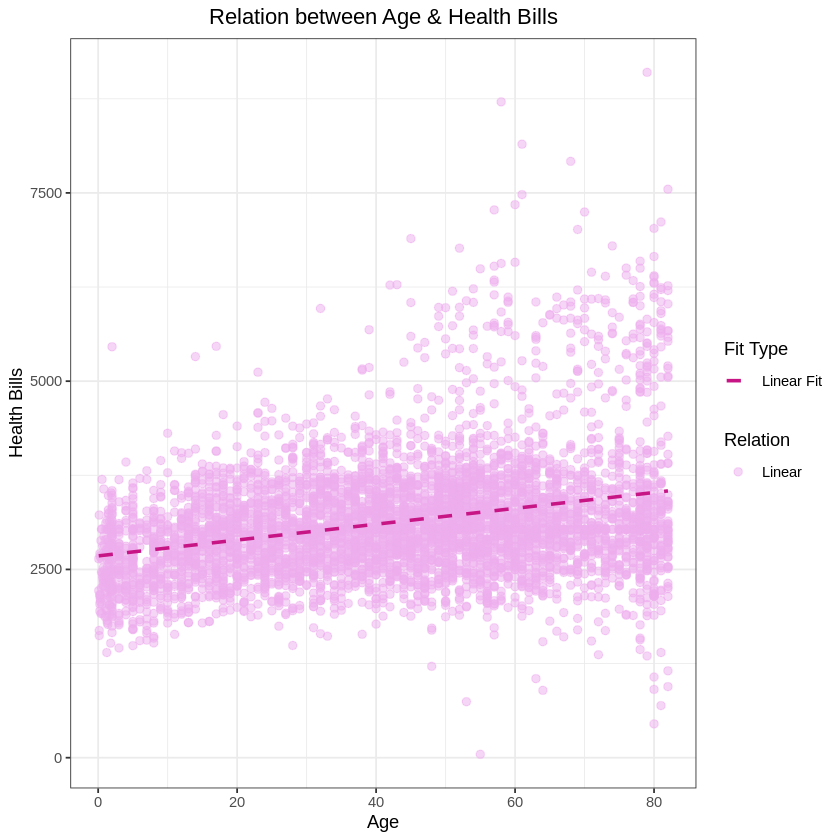

In [ ]:
ageScatter <- ggplot(healthCare, aes(x = age))
ageScatter <- ageScatter + geom_point(aes(y = health_bills, color = "Linear"), size = 2, alpha = 0.5)
ageScatter <- ageScatter + stat_smooth(aes(x = age, y = health_bills, linetype = "Linear Fit"),
              method = "lm", formula = y ~ x, se = F, color = "mediumvioletred") 
ageScatter <- ageScatter + scale_color_manual(name = "Relation", values = c("plum2", "thistle1")) 
ageScatter <- ageScatter + scale_linetype_manual(name = "Fit Type", values = c(2, 2)) 
ageScatter <- ageScatter + xlab("Age")
ageScatter <- ageScatter + ylab("Health Bills")
ageScatter <- ageScatter + ggtitle("Relation between Age & Health Bills")
ageScatter <- ageScatter + theme_bw()
ageScatter <- ageScatter + theme(plot.title = element_text(hjust = 0.5))
ageScatter

#### __Part C__
One of the important metrics in comparing two predictors is p-value. For both variables this value is less than 2.2e-16. The lower the p-value is, The better the predictor will be. The parameter is identical for these two variables. Therefore we can not compare them in this way. 

Another thing that we can consider is variability of data points around the least squares line. It should be constant. As we can see, vriability in *BMI* scatter plot is less than *Age*. So, it seems that *BMI* is better predictor than *Age*.

#### __Part D__
**Adjusted R-squared**

One of the important metrics in comparing two predictors is the value of adjusted R-squared. Based on the results of the previous part, this metric for *BMI* is 0.1784 and for *Age* is 0.09172. The greater the adjusted R-squared is, the better the predictor is. As a result, **BMI** is better predictor than *Age*.

**ANOVA table**
We have following formula to compute adjusted R-squared from ANOVA table.


$$R^2_{adj} = 1 - (\frac{SSE}{SST} \times \frac{n - 1}{n - k - 1})$$

k: number of predictors

At first, we make ANOVA table for *BMI* predictor. For this goal, we will use `anova()` method.

In [ ]:
bmiANOVA <- anova(bmiModel)
bmiANOVA

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
bmi,1,596037498,596037497.5,1109.321,2.72593e-220
Residuals,5107,2743987063,537299.2,NA,NA


In this step, we will write a method to compute adjusted R-squared from ANOVA table based on the above formula.

In [ ]:
getAdjR2 <- function(anovaTable, pred) {
  n <- length(healthCare[pred])
  SSR <- anovaTable[pred, "Sum Sq"]
  SSE <- anovaTable["Residuals", "Sum Sq"]
  SST <- SSE + SSR
  adjR2 <- 1 - (SSE / SST * (5109 - 1) / (5109 - 1 - 1))
  return(adjR2)
}

Now we call this function for *BMI* model.

In [ ]:
getAdjR2(bmiANOVA, "bmi")

[1] 0.1782922

Based on the result, computed adjusted R-squared is as same as what we get by calling `lm()` method.

Now will repeat these tasks for *Age* as a predictor.

In [ ]:
ageANOVA <- anova(ageModel)
ageANOVA

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
age,1,289202015,289202015.3,484.1169,1.387186e-102
Residuals,5107,3050822546,597380.6,NA,NA


In [ ]:
getAdjR2(ageANOVA, "age")

[1] 0.08640794

As we can see, thse is no difference between this value and the value obtained from `lm()`.

To wrap up, *BMI* is a better predictor than *Age*.

#### __Part E__
Based on the results of previous part, I made a list of features of a good predictorl.


*   It cause the model to have lower p-value.
*   Variability of data points around its least squares line is fewer.
*   It increases the adjusted R-squared of the model.




#### __Part F__


###### __a__

In [ ]:
nSample <- 100
nTrain <- 90
set.seed(123)
sampleRows <- sample(nrow(healthCare), nSample)
sampleData <- healthCare[sampleRows,]

In [ ]:
# Split data into train and test
index <- createDataPartition(sampleData$health_bills, p = .90, list = FALSE)
train <- sampleData[index, ]
test <- sampleData[-index, ]

In [ ]:
bmiSampleModel <- lm(health_bills ~ bmi, data = train)
summary(bmiSampleModel)


Call:
lm(formula = health_bills ~ bmi, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-1060.9  -427.2   -48.7   354.2  3349.3 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2228.30     242.38   9.194 1.36e-14 ***
bmi            28.41       8.04   3.534 0.000649 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 664.2 on 90 degrees of freedom
Multiple R-squared:  0.1218,	Adjusted R-squared:  0.1121 
F-statistic: 12.49 on 1 and 90 DF,  p-value: 0.0006492


In [ ]:
ageSampleModel <- lm(health_bills ~ age, data = train)
summary(ageSampleModel)


Call:
lm(formula = health_bills ~ age, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1331.58  -427.62   -52.61   336.63  2883.09 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2630.800    158.497  16.598  < 2e-16 ***
age            9.521      3.230   2.947  0.00408 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 676.8 on 90 degrees of freedom
Multiple R-squared:  0.08802,	Adjusted R-squared:  0.07789 
F-statistic: 8.687 on 1 and 90 DF,  p-value: 0.004082


###### __b__

In [ ]:
confint(bmiSampleModel)

,2.5 %,97.5 %
(Intercept),1746.77759,2709.82396
bmi,12.43735,44.38155


In [ ]:
confint(ageSampleModel)

,2.5 %,97.5 %
(Intercept),2315.918807,2945.68110
age,3.103285,15.93904


###### __c__

In [ ]:
bmiModelPreds <- predict(bmiSampleModel, newdata = test, type=c("response"))

###### __d__

In [ ]:
summary(healthCare$health_bills)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   44.8  2647.8  3032.2  3134.6  3454.9  9100.5 

In [ ]:
actual <- test$health_bills

In [ ]:
abs(bmiModelPreds - actual)

526       2986       2980        555        277       1006       2339 
 818.18009 1134.55800  485.22286   52.80268  325.82638  367.37662  361.75148 
      4262 
 468.77068

We consider for difference the threshold of 600 and it is obtained from what we can see in the summary. So, the success rate would be 70% which is above 50% and it seems that we have a good model.

### __Question 5__

#### __Part A__
In this part, we will plot correlogram for numerical variables. In first figure, we used `pairs()` method and in second figure, we  we used ggcorrplot() from ggcorrplot library to plot to create a heatmap correlogram from our features. Also, we used cor_pmat() method to compute matrix of p-value. Finally, we set the significance level to 0.05.

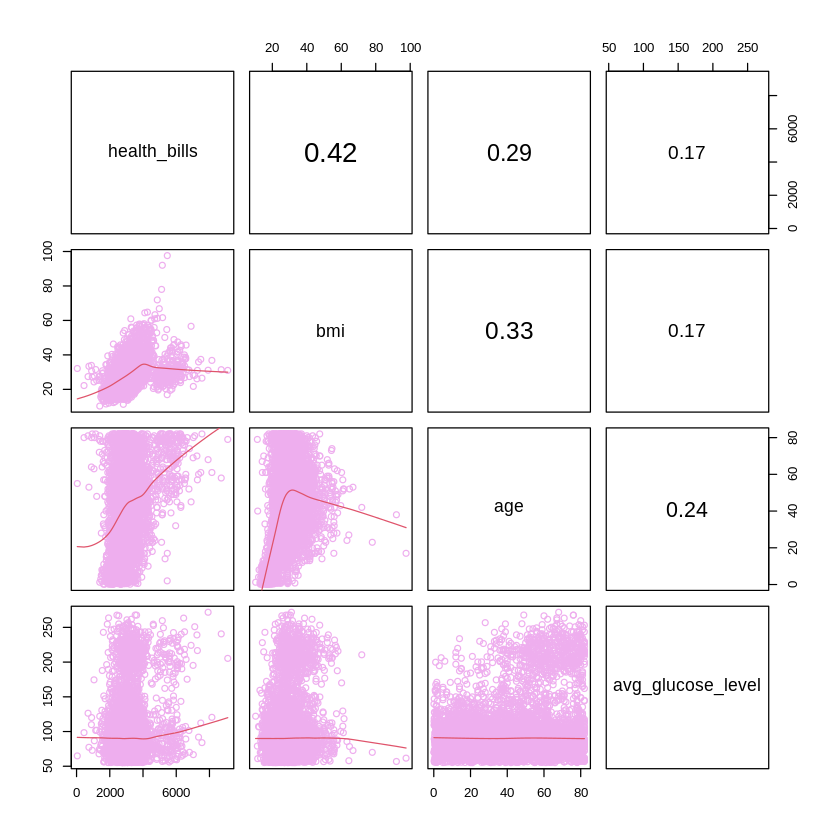

In [ ]:
panel.cor <- function(x, y, digits = 2, prefix = "", cex.cor, ...) {
    usr <- par("usr")
    on.exit(par(usr))
    par(usr = c(0, 1, 0, 1))
    Cor <- abs(cor(x, y))
    txt <- paste0(prefix, format(c(Cor, 0.123456789), digits = digits)[1])
    if(missing(cex.cor)) {
        cex.cor <- 0.4 / strwidth(txt)
    }
    text(0.5, 0.5, txt,
         cex = 1 + cex.cor * Cor)
}

pairs(health_bills ~ bmi + age + avg_glucose_level, data=healthCare,
      upper.panel = panel.cor,  
      lower.panel = panel.smooth, col="plum2")

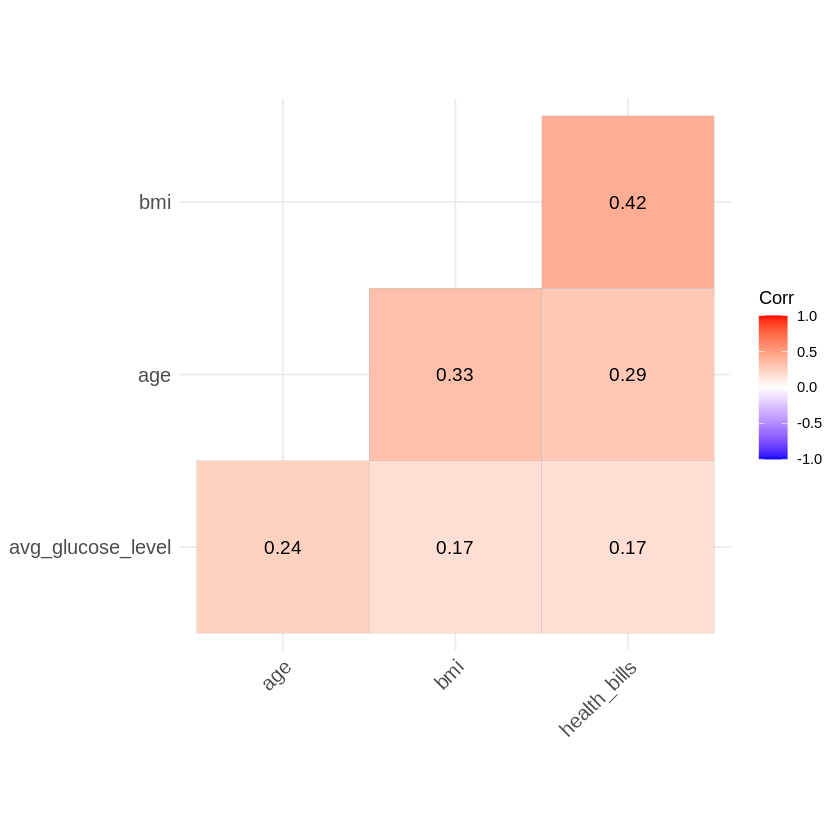

In [ ]:
numericVars <- healthCare[c("age", "avg_glucose_level", "bmi", "health_bills")]
corr <- cor(numericVars)
p.mat <- cor_pmat(numericVars)
ggcorrplot(corr, hc.order = TRUE, type = "lower", lab = TRUE, p.mat = p.mat, sig.level = 0.05)

Based on the results, the highest correlation is between BMI and Health Bills. Is means that BMI is the most effective predictor for this value. Also, it would be of importance to consider Age as a predictor. Because it has a high correlation with our response variable.

#### __Part B__
In this part, we consider *BMI* and *Age* as predictors in our multiple linear regression model.

In [ ]:
selectedModel <- lm(health_bills ~ bmi + age, data = healthCare)
summary(selectedModel)


Call:
lm(formula = health_bills ~ bmi + age, data = healthCare)

Residuals:
    Min      1Q  Median      3Q     Max 
-3286.5  -421.1   -80.5   281.5  5661.1 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1754.8765    39.8535   44.03   <2e-16 ***
bmi           38.3761     1.3856   27.70   <2e-16 ***
age            6.2651     0.4717   13.28   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 720.7 on 5106 degrees of freedom
Multiple R-squared:  0.2059,	Adjusted R-squared:  0.2056 
F-statistic: 661.9 on 2 and 5106 DF,  p-value: < 2.2e-16


#### __Part C__

Based on the results of previous parts, R-squared is 0.2059. Therefore we can conclude that 20.59% of variability in health bills is explained by our model.

#### __Part D__
It is a good model. Because its p-value is too small and we can conclude that our model is statistcally significant. Its adjsusted R-squared is approriate but there is a potential to reach higher value by considering more predictors.

#### __Part E__

**Backwards Elimination - Adjusted R-squared**

In this method, we start with the full model. At each step, we drop one variable at a time and record adjusted R-squared
of each smaller model. Then, we pick the model with the highest increase in adjusted R-squared.

We repeat until none of the models yield an increase in 
adjusted R-squared.


In [ ]:
full <- lm(health_bills ~ bmi + age + avg_glucose_level, data = healthCare)
summary(full)


Call:
lm(formula = health_bills ~ bmi + age + avg_glucose_level, data = healthCare)

Residuals:
    Min      1Q  Median      3Q     Max 
-3225.0  -422.1   -76.8   286.2  5554.4 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       1663.8185    42.9576  38.732  < 2e-16 ***
bmi                 37.6063     1.3884  27.086  < 2e-16 ***
age                  5.7387     0.4797  11.964  < 2e-16 ***
avg_glucose_level    1.2819     0.2298   5.579 2.54e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 718.6 on 5105 degrees of freedom
Multiple R-squared:  0.2107,	Adjusted R-squared:  0.2102 
F-statistic: 454.3 on 3 and 5105 DF,  p-value: < 2.2e-16


We can see that adjusted R-squared for the full model is 0.2102.

**Step 1**

In [ ]:
step1dropBMI <- lm(health_bills ~ age + avg_glucose_level, data = healthCare)
summary(step1dropBMI)


Call:
lm(formula = health_bills ~ age + avg_glucose_level, data = healthCare)

Residuals:
    Min      1Q  Median      3Q     Max 
-3124.6  -475.7   -82.4   342.7  5433.5 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       2517.2050    31.2260  80.612  < 2e-16 ***
age                  9.6152     0.4896  19.640  < 2e-16 ***
avg_glucose_level    1.9004     0.2445   7.773 9.18e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 768.4 on 5106 degrees of freedom
Multiple R-squared:  0.09727,	Adjusted R-squared:  0.09692 
F-statistic: 275.1 on 2 and 5106 DF,  p-value: < 2.2e-16


In [ ]:
step1dropAge <- lm(health_bills ~ bmi + avg_glucose_level, data = healthCare)
summary(step1dropAge)


Call:
lm(formula = health_bills ~ bmi + avg_glucose_level, data = healthCare)

Residuals:
    Min      1Q  Median      3Q     Max 
-3151.1  -425.4   -79.4   265.0  5695.6 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       1711.3171    43.3650   39.46  < 2e-16 ***
bmi                 42.5622     1.3435   31.68  < 2e-16 ***
avg_glucose_level    1.8225     0.2284    7.98 1.79e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 728.5 on 5106 degrees of freedom
Multiple R-squared:  0.1886,	Adjusted R-squared:  0.1883 
F-statistic: 593.3 on 2 and 5106 DF,  p-value: < 2.2e-16


In [ ]:
step1dropGlucose <- lm(health_bills ~ bmi + age, data = healthCare)
summary(step1dropGlucose)


Call:
lm(formula = health_bills ~ bmi + age, data = healthCare)

Residuals:
    Min      1Q  Median      3Q     Max 
-3286.5  -421.1   -80.5   281.5  5661.1 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1754.8765    39.8535   44.03   <2e-16 ***
bmi           38.3761     1.3856   27.70   <2e-16 ***
age            6.2651     0.4717   13.28   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 720.7 on 5106 degrees of freedom
Multiple R-squared:  0.2059,	Adjusted R-squared:  0.2056 
F-statistic: 661.9 on 2 and 5106 DF,  p-value: < 2.2e-16


Based on the result, none of the above models yield an increase in adjusted R-squared. So, it means that full model is the best model in this method.

**Backwards Elimination - p-value**

In this method, we start with the full model. At each step we drop the variable with the highest p-value and refit a 
smaller model.

We repeat until all variables left in the model are significant.

In [ ]:
full <- lm(health_bills ~ bmi + age + avg_glucose_level, data = healthCare)
summary(full)


Call:
lm(formula = health_bills ~ bmi + age + avg_glucose_level, data = healthCare)

Residuals:
    Min      1Q  Median      3Q     Max 
-3225.0  -422.1   -76.8   286.2  5554.4 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       1663.8185    42.9576  38.732  < 2e-16 ***
bmi                 37.6063     1.3884  27.086  < 2e-16 ***
age                  5.7387     0.4797  11.964  < 2e-16 ***
avg_glucose_level    1.2819     0.2298   5.579 2.54e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 718.6 on 5105 degrees of freedom
Multiple R-squared:  0.2107,	Adjusted R-squared:  0.2102 
F-statistic: 454.3 on 3 and 5105 DF,  p-value: < 2.2e-16


Based on the result, all the predictors in our full model are significant. So, we report this model as the best model that can be achieved by this method.

**Forward Selection - Adjusted R-squared**

In this method, we start with single predictor regressions of response vs. each explanatory variable. we pick the model with the highest adjusted R-squared, add the remaining variables one at a time to the existing 
model, and pick the model with the highest adjusted R-squared.

we repeat until the addition of any of the remaining variables does not result in a higher adjusted R-squared.


**Step 1**

In [ ]:
step1selectBMI <- lm(health_bills ~ bmi, data = healthCare)
summary(step1selectBMI)


Call:
lm(formula = health_bills ~ bmi, data = healthCare)

Residuals:
    Min      1Q  Median      3Q     Max 
-3232.0  -429.8  -102.3   258.3  5872.5 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1852.434     39.838   46.50   <2e-16 ***
bmi           44.373      1.332   33.31   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 733 on 5107 degrees of freedom
Multiple R-squared:  0.1785,	Adjusted R-squared:  0.1783 
F-statistic:  1109 on 1 and 5107 DF,  p-value: < 2.2e-16


In [ ]:
step1selectAge <- lm(health_bills ~ age, data = healthCare)
summary(step1selectAge)


Call:
lm(formula = health_bills ~ age, data = healthCare)

Residuals:
    Min      1Q  Median      3Q     Max 
-3213.6  -465.1   -90.5   338.2  5589.6 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2679.7026    23.3308   114.9   <2e-16 ***
age           10.5222     0.4782    22.0   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 772.9 on 5107 degrees of freedom
Multiple R-squared:  0.08659,	Adjusted R-squared:  0.08641 
F-statistic: 484.1 on 1 and 5107 DF,  p-value: < 2.2e-16


In [ ]:
step1selectGlucose <- lm(health_bills ~ avg_glucose_level, data = healthCare)
summary(step1selectGlucose)


Call:
lm(formula = health_bills ~ avg_glucose_level, data = healthCare)

Residuals:
    Min      1Q  Median      3Q     Max 
-2964.3  -480.4   -98.0   329.3  5664.0 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       2811.4146    28.4115   98.95   <2e-16 ***
avg_glucose_level    3.0447     0.2462   12.37   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 796.9 on 5107 degrees of freedom
Multiple R-squared:  0.02907,	Adjusted R-squared:  0.02888 
F-statistic: 152.9 on 1 and 5107 DF,  p-value: < 2.2e-16


Based on what we can see, bmi is the predictor with the highest adjusted R-squared. So, we select it for this step.

**Step 2**

In [ ]:
step2selectAge <- lm(health_bills ~ bmi + age, data = healthCare)
summary(step2selectAge)


Call:
lm(formula = health_bills ~ bmi + age, data = healthCare)

Residuals:
    Min      1Q  Median      3Q     Max 
-3286.5  -421.1   -80.5   281.5  5661.1 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1754.8765    39.8535   44.03   <2e-16 ***
bmi           38.3761     1.3856   27.70   <2e-16 ***
age            6.2651     0.4717   13.28   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 720.7 on 5106 degrees of freedom
Multiple R-squared:  0.2059,	Adjusted R-squared:  0.2056 
F-statistic: 661.9 on 2 and 5106 DF,  p-value: < 2.2e-16


In [ ]:
step2selectGlucose <- lm(health_bills ~ bmi + avg_glucose_level, data = healthCare)
summary(step2selectGlucose)


Call:
lm(formula = health_bills ~ bmi + avg_glucose_level, data = healthCare)

Residuals:
    Min      1Q  Median      3Q     Max 
-3151.1  -425.4   -79.4   265.0  5695.6 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       1711.3171    43.3650   39.46  < 2e-16 ***
bmi                 42.5622     1.3435   31.68  < 2e-16 ***
avg_glucose_level    1.8225     0.2284    7.98 1.79e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 728.5 on 5106 degrees of freedom
Multiple R-squared:  0.1886,	Adjusted R-squared:  0.1883 
F-statistic: 593.3 on 2 and 5106 DF,  p-value: < 2.2e-16


Based on what we can see, by adding age we can reach the highest adjusted R-squared. So, we select it for this step.

**Step 3**

In [ ]:
step3selectGlucose <- lm(health_bills ~ bmi + age + avg_glucose_level, data = healthCare)
summary(step3selectGlucose)


Call:
lm(formula = health_bills ~ bmi + age + avg_glucose_level, data = healthCare)

Residuals:
    Min      1Q  Median      3Q     Max 
-3225.0  -422.1   -76.8   286.2  5554.4 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       1663.8185    42.9576  38.732  < 2e-16 ***
bmi                 37.6063     1.3884  27.086  < 2e-16 ***
age                  5.7387     0.4797  11.964  < 2e-16 ***
avg_glucose_level    1.2819     0.2298   5.579 2.54e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 718.6 on 5105 degrees of freedom
Multiple R-squared:  0.2107,	Adjusted R-squared:  0.2102 
F-statistic: 454.3 on 3 and 5105 DF,  p-value: < 2.2e-16


Based on what we can see, by adding glucose we can reach greater adjusted R-squared in comparison to last step. So, we select it for this step.

As you see, we reach our full model. It means that this is the best model than develop from our data.

**Forward Selection - p-value**

In this method, we start with single predictor regressions of response vs. each explanatory variable, pick the variable with the lowest significant p-value. we add the remaining variables one at a time to the existing 
model, and pick the variable with the lowest significant 
p-value. 

We repeat until any of the remaining variables do not have a significant p-value.


**Step 1**

In [ ]:
step1selectBMI <- lm(health_bills ~ bmi, data = healthCare)
summary(step1selectBMI)


Call:
lm(formula = health_bills ~ bmi, data = healthCare)

Residuals:
    Min      1Q  Median      3Q     Max 
-3232.0  -429.8  -102.3   258.3  5872.5 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1852.434     39.838   46.50   <2e-16 ***
bmi           44.373      1.332   33.31   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 733 on 5107 degrees of freedom
Multiple R-squared:  0.1785,	Adjusted R-squared:  0.1783 
F-statistic:  1109 on 1 and 5107 DF,  p-value: < 2.2e-16


In [ ]:
step1selectAge <- lm(health_bills ~ age, data = healthCare)
summary(step1selectAge)


Call:
lm(formula = health_bills ~ age, data = healthCare)

Residuals:
    Min      1Q  Median      3Q     Max 
-3213.6  -465.1   -90.5   338.2  5589.6 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2679.7026    23.3308   114.9   <2e-16 ***
age           10.5222     0.4782    22.0   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 772.9 on 5107 degrees of freedom
Multiple R-squared:  0.08659,	Adjusted R-squared:  0.08641 
F-statistic: 484.1 on 1 and 5107 DF,  p-value: < 2.2e-16


In [ ]:
step1selectGlucose <- lm(health_bills ~ avg_glucose_level, data = healthCare)
summary(step1selectGlucose)


Call:
lm(formula = health_bills ~ avg_glucose_level, data = healthCare)

Residuals:
    Min      1Q  Median      3Q     Max 
-2964.3  -480.4   -98.0   329.3  5664.0 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       2811.4146    28.4115   98.95   <2e-16 ***
avg_glucose_level    3.0447     0.2462   12.37   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 796.9 on 5107 degrees of freedom
Multiple R-squared:  0.02907,	Adjusted R-squared:  0.02888 
F-statistic: 152.9 on 1 and 5107 DF,  p-value: < 2.2e-16


Based on the resut, p-value for all the predictors is less than 2.2e-16. So, there is no difference and we can choose one of them for this step. I want to choose bmi.

**Step 2**

In [ ]:
step2selectAge <- lm(health_bills ~ bmi + age, data = healthCare)
summary(step2selectAge)


Call:
lm(formula = health_bills ~ bmi + age, data = healthCare)

Residuals:
    Min      1Q  Median      3Q     Max 
-3286.5  -421.1   -80.5   281.5  5661.1 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1754.8765    39.8535   44.03   <2e-16 ***
bmi           38.3761     1.3856   27.70   <2e-16 ***
age            6.2651     0.4717   13.28   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 720.7 on 5106 degrees of freedom
Multiple R-squared:  0.2059,	Adjusted R-squared:  0.2056 
F-statistic: 661.9 on 2 and 5106 DF,  p-value: < 2.2e-16


In [ ]:
step2selectGlucose <- lm(health_bills ~ bmi + avg_glucose_level, data = healthCare)
summary(step2selectGlucose)


Call:
lm(formula = health_bills ~ bmi + avg_glucose_level, data = healthCare)

Residuals:
    Min      1Q  Median      3Q     Max 
-3151.1  -425.4   -79.4   265.0  5695.6 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       1711.3171    43.3650   39.46  < 2e-16 ***
bmi                 42.5622     1.3435   31.68  < 2e-16 ***
avg_glucose_level    1.8225     0.2284    7.98 1.79e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 728.5 on 5106 degrees of freedom
Multiple R-squared:  0.1886,	Adjusted R-squared:  0.1883 
F-statistic: 593.3 on 2 and 5106 DF,  p-value: < 2.2e-16


Based on what we can see that age has the lowest p-value. So, we choose it for this step.

**Step 3**

In [ ]:
step3selectGlucose <- lm(health_bills ~ bmi + age + avg_glucose_level, data = healthCare)
summary(step3selectGlucose)


Call:
lm(formula = health_bills ~ bmi + age + avg_glucose_level, data = healthCare)

Residuals:
    Min      1Q  Median      3Q     Max 
-3225.0  -422.1   -76.8   286.2  5554.4 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       1663.8185    42.9576  38.732  < 2e-16 ***
bmi                 37.6063     1.3884  27.086  < 2e-16 ***
age                  5.7387     0.4797  11.964  < 2e-16 ***
avg_glucose_level    1.2819     0.2298   5.579 2.54e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 718.6 on 5105 degrees of freedom
Multiple R-squared:  0.2107,	Adjusted R-squared:  0.2102 
F-statistic: 454.3 on 3 and 5105 DF,  p-value: < 2.2e-16


Based on the result, glucose has  a significant p-value. So, we add it to our model. This was the last predictor. So, we reached our best model which is the full model.

**Conclusion**

Our full model (with numerical predictors only) is the best model that we can develop to predict health bills.

In [ ]:
best <- full

#### __Part F__
**Linearity**

Each explanatory variable should be linearly related to the 
response variable. We will check this condition using residuals plots. We are looking for a random scatter around 0.

`geom_smooth()` using formula 'y ~ x'



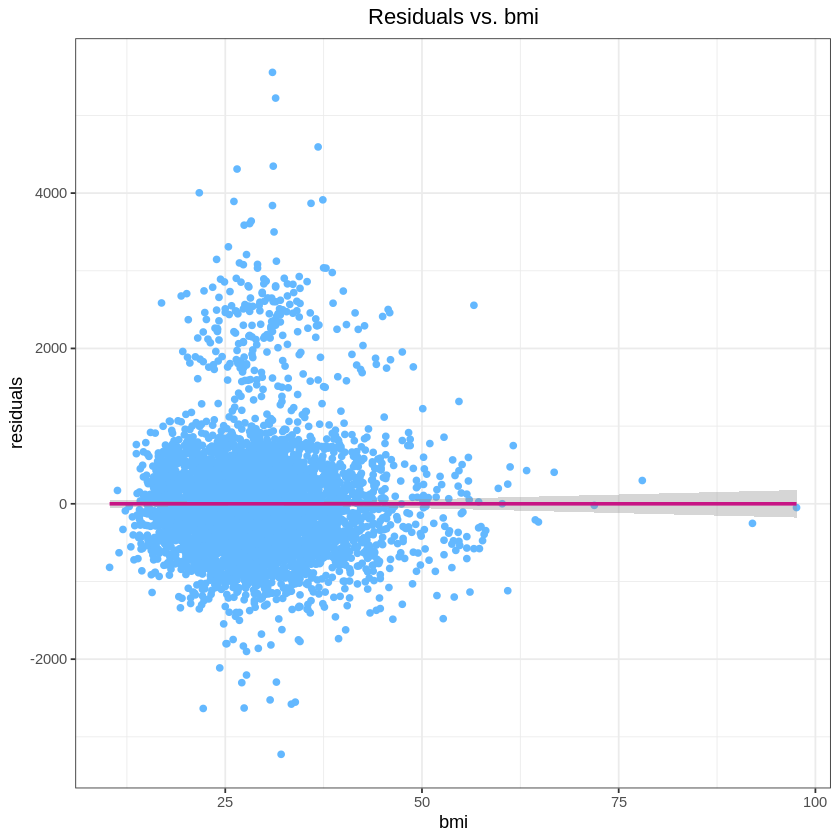

In [ ]:
data <- data.frame(residuals=best$residuals, bmi=healthCare$bmi)
 
bmiRes <- ggplot(data = data, aes(bmi, residuals))
bmiRes <- bmiRes + geom_point(color = "steelblue1")
bmiRes <- bmiRes + stat_smooth(method = lm, color="mediumvioletred")
bmiRes <- bmiRes + ggtitle("Residuals vs. bmi")
bmiRes <- bmiRes + theme_bw()
bmiRes <- bmiRes + theme(plot.title = element_text(hjust = 0.5))
bmiRes

`geom_smooth()` using formula 'y ~ x'



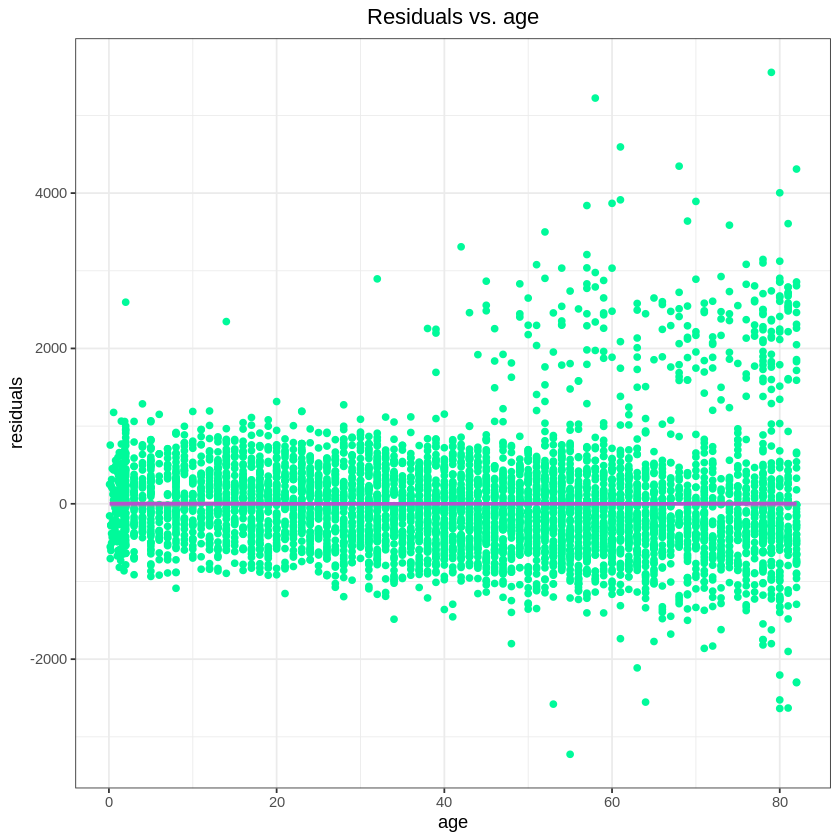

In [ ]:
data <- data.frame(residuals=best$residuals, age=healthCare$age)
 
ageRes <- ggplot(data = data, aes(age, residuals))
ageRes <- ageRes + geom_point(color = "mediumspringgreen")
ageRes <- ageRes + stat_smooth(method = lm, color="mediumorchid3")
ageRes <- ageRes + ggtitle("Residuals vs. age")
ageRes <- ageRes + theme_bw()
ageRes <- ageRes + theme(plot.title = element_text(hjust = 0.5))
ageRes

`geom_smooth()` using formula 'y ~ x'



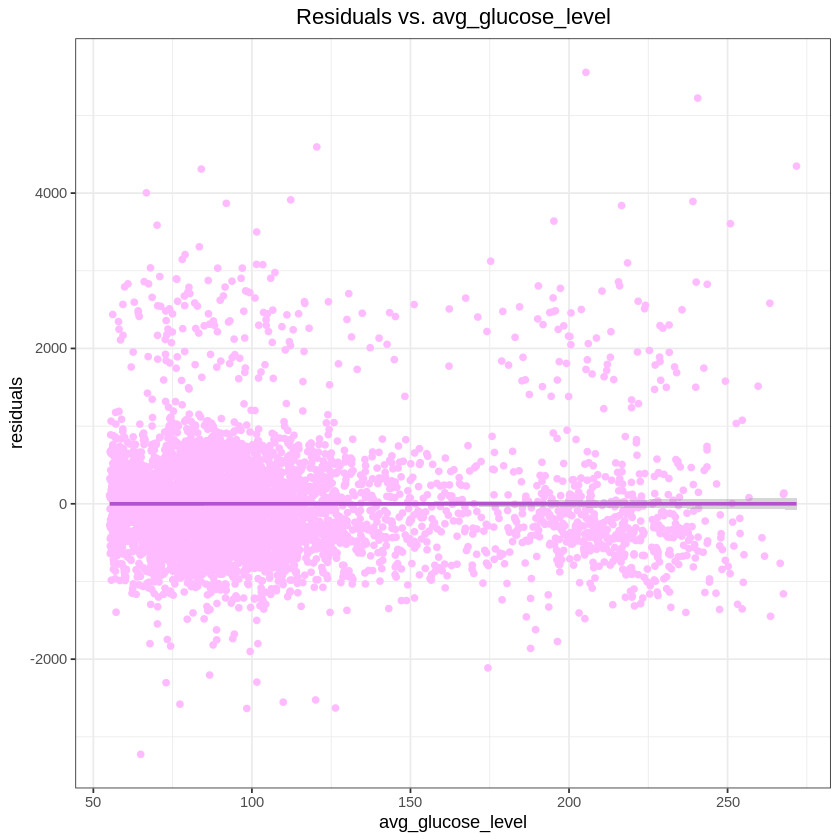

In [ ]:
data <- data.frame(residuals=best$residuals, avg_glucose_level=healthCare$avg_glucose_level)
 
glucoseRes <- ggplot(data = data, aes(avg_glucose_level, residuals))
glucoseRes <- glucoseRes + geom_point(color = "plum1")
glucoseRes <- glucoseRes + stat_smooth(method = lm, color="mediumorchid3")
glucoseRes <- glucoseRes + ggtitle("Residuals vs. avg_glucose_level")
glucoseRes <- glucoseRes + theme_bw()
glucoseRes <- glucoseRes + theme(plot.title = element_text(hjust = 0.5))
glucoseRes

Baed on the result, in each plot there is a horizontal line with the zero slope which can be fit on residuals. Therefore, we can comclude that linearity condtion is satisfied.


**Nearly normal residuals**

We will check this condition using histogram and normal probability plot.

**Histogram**


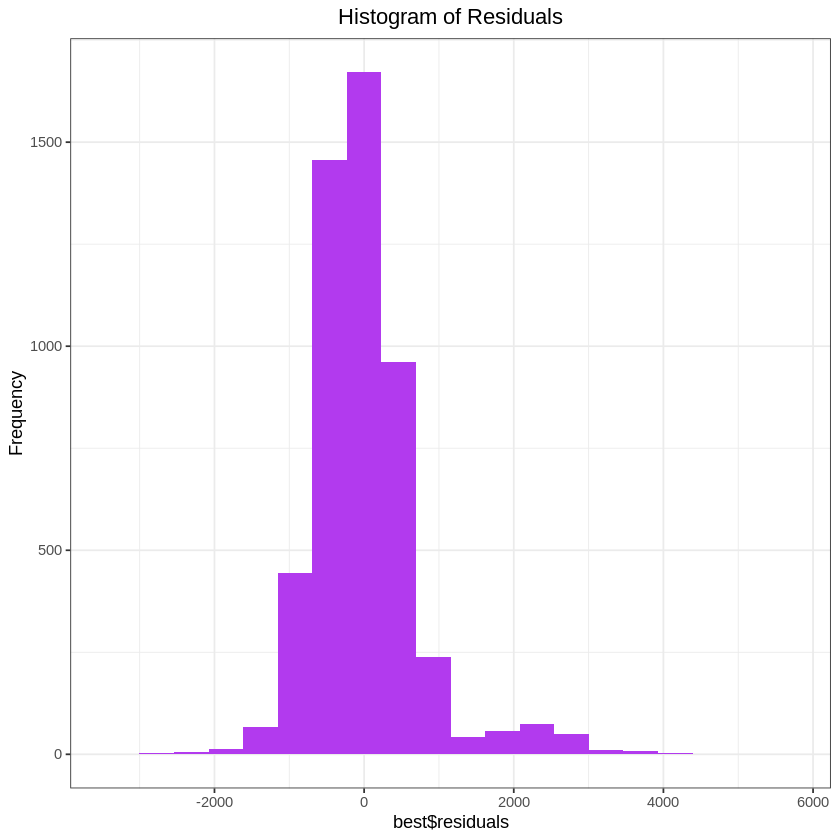

In [ ]:
modelHist <- ggplot(data=best, aes(best$residuals))
modelHist <- modelHist + geom_histogram(bins=20, fill="darkorchid2")
modelHist <- modelHist + ylab("Frequency")
modelHist <- modelHist + ggtitle("Histogram of Residuals")
modelHist <- modelHist + theme_bw()
modelHist <- modelHist + theme(plot.title = element_text(hjust = 0.5))
modelHist

Based on the result, we can say that residuals have a nearly normal distribution. So, this condition is met.

**QQ Plot**



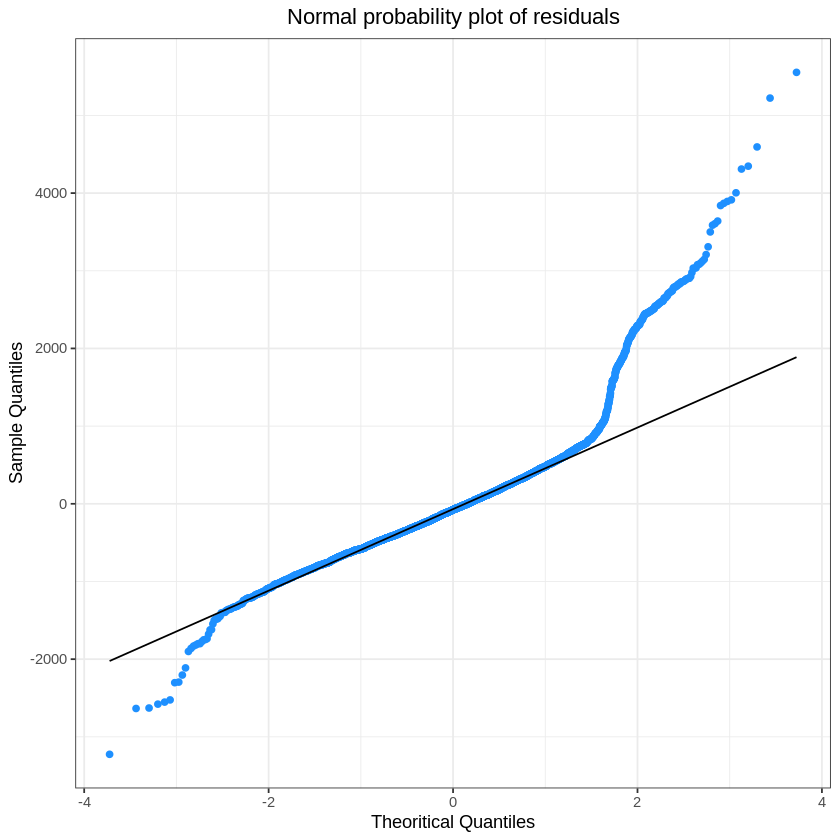

In [ ]:
modelQQ <- ggplot(best, aes(sample=best$residuals))
modelQQ <- modelQQ + stat_qq(col="dodgerblue") 
modelQQ <- modelQQ + stat_qq_line() 
modelQQ <- modelQQ + ylab("Sample Quantiles")
modelQQ <- modelQQ + xlab("Theoritical Quantiles")
modelQQ <- modelQQ + ggtitle("Normal probability plot of residuals")
modelQQ <- modelQQ + theme_bw()
modelQQ <- modelQQ + theme(plot.title = element_text(hjust = 0.5))
modelQQ

Based on the result, tails are a bit different from normal plot. But we will check the remaining condition and test our model later.

**Constant variability**

 Residuals should be equally variable for low and high values of the predicted response variable.

We will check it using residuals plots of residuals vs. predicted. 


`geom_smooth()` using formula 'y ~ x'



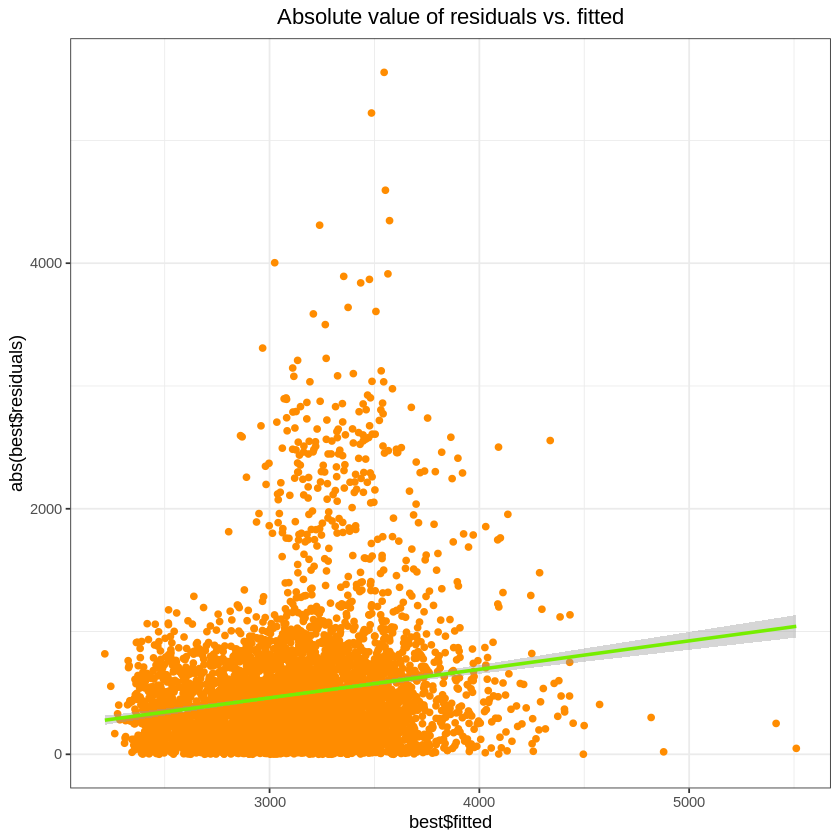

In [ ]:
modelRes <- ggplot(data = best, aes(best$fitted, abs(best$residuals)))
modelRes <- modelRes + geom_point(color = "darkorange")
modelRes <- modelRes + stat_smooth(method = lm, color="chartreuse2")
modelRes <- modelRes + ggtitle("Absolute value of residuals vs. fitted")
modelRes <- modelRes + theme_bw()
modelRes <- modelRes + theme(plot.title = element_text(hjust = 0.5))
modelRes

`geom_smooth()` using formula 'y ~ x'



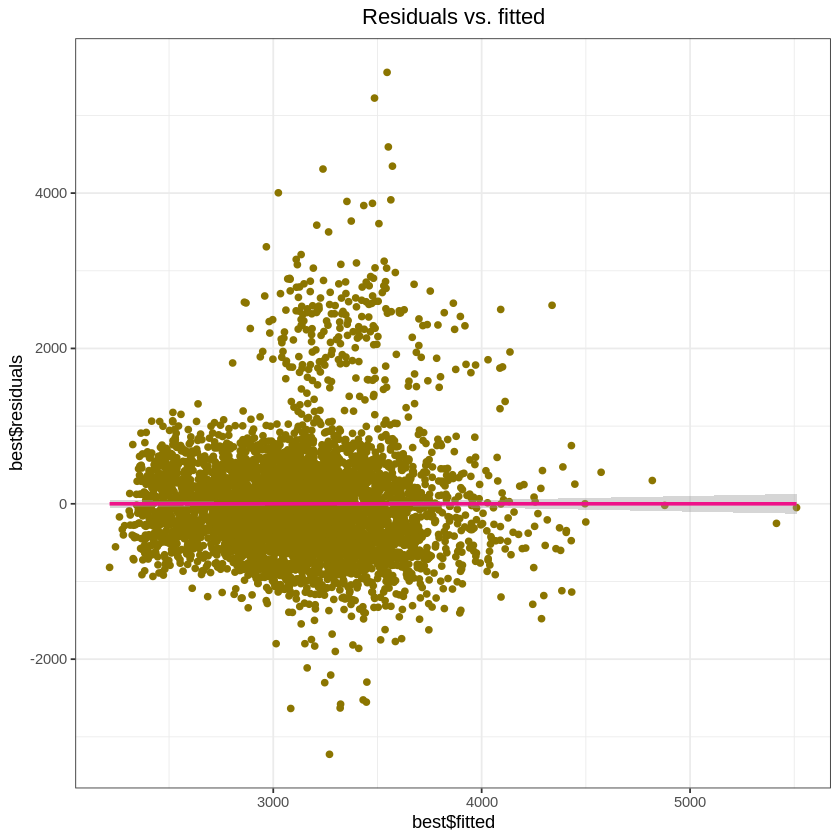

In [ ]:
modelRes <- ggplot(data = best, aes(best$fitted, best$residuals))
modelRes <- modelRes + geom_point(color = "gold4")
modelRes <- modelRes + stat_smooth(method = lm, color="deeppink2")
modelRes <- modelRes + ggtitle("Residuals vs. fitted")
modelRes <- modelRes + theme_bw()
modelRes <- modelRes + theme(plot.title = element_text(hjust = 0.5))
modelRes

Based on the results, there is a linear model with the slope equals zero that can be fit on residuals. To sum up, we can say all the conditions are met for this model and we can rely on it predictions.

#### __Part G__

**K-Fold Cross Validation**

K-Fold Cross Validation is where a given data set is split into a K number of sections/folds where each fold is used as a testing set at some point. 

In 5-Fold cross validation(K=5), the data set is split into 5 folds. In the first iteration, the first fold is used to test the model and the rest are used to train the model. In the second iteration, 2nd fold is used as the testing set while the rest serve as the training set. This process is repeated until each fold of the 5 folds have been used as the testing set.

We use `trainControl()` function to define 5-fold cv as our control method.



In [ ]:
trainControl <- trainControl(method="cv", number=5)

Now, we use `train()` method to run this test on the model that we defined in part B.

In [ ]:
myCrossVal <- train(health_bills ~ bmi + age, data=healthCare,
                  trControl=trainControl, method="lm")
myCrossVal

Linear Regression 

5109 samples
   2 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 4089, 4086, 4085, 4087, 4089 
Resampling results:

  RMSE     Rsquared   MAE     
  720.609  0.2055299  490.8399

Tuning parameter 'intercept' was held constant at a value of TRUE

Based on the result, RMSE  for the model of part B is 720.2921.

The formula of this metric is as follows:
$$RMSE = \sqrt{\sum_{i=1}^{n}{\frac{(\hat{y_i}-y_i)^2}{n}}}$$

Root Mean Square Error (RMSE) is a standard way to measure the error of a model in predicting quantitative data.  It measures how spread out the residuals are. In other words, it is the standard deviation of the unexplained variance.
One of its benefits is that it has the same unit as data.

By using this metric, we can compare the accuracy of our models. The smaller the RMSE is, the more successful our model is in predicting response variable.

In [ ]:
bestCrossVal <- train(health_bills ~ bmi + age + avg_glucose_level, data=healthCare,
                  trControl=trainControl, method="lm")
bestCrossVal

Linear Regression 

5109 samples
   3 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 4088, 4085, 4087, 4088, 4088 
Resampling results:

  RMSE      Rsquared   MAE     
  718.4328  0.2107306  491.6144

Tuning parameter 'intercept' was held constant at a value of TRUE

Based on the result, RMSE  for the model of part E is 718.4328.

Its RMSE is less than what we found for model of part B. It shows that it is better model and we can rely on the statical methods that we used to reach this model.


### __Question 6__
For this question, we select **Heart Disease** as a categorical response variable, **Age** as a numerical explanatory variable, and **Gender** as a categogorical explanatory variable.

#### __Part A__

Wew will use `glm()` method to create our model.

In [ ]:
myModel <- glm(heart_disease ~ age + gender, family = binomial, data = healthCare)
summary(myModel)


Call:
glm(formula = heart_disease ~ age + gender, family = binomial, 
    data = healthCare)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9895  -0.3358  -0.1654  -0.0717   3.7020  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -7.880882   0.352513 -22.356  < 2e-16 ***
age          0.079898   0.004962  16.100  < 2e-16 ***
genderMale   0.869806   0.133519   6.514 7.29e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2147.7  on 5108  degrees of freedom
Residual deviance: 1667.2  on 5106  degrees of freedom
AIC: 1673.2

Number of Fisher Scoring iterations: 7


By using `exp()` we get odds ratio of predictors.

In [ ]:
exp(cbind(coef(myModel)))

(Intercept),0.0003778995
age,1.0831765490
genderMale,2.3864489565


**Gender slope**

**In terms of log odds ratio:**

When the other predictors are held constant, 
the log odds ratio of having heart disease for men are 0.869806 higher than women.

**In terms of odds ratio:**

When the other predictors are held constant, the odds ratio of having heart disease for males is 2.3864489565 times of the odds ratio of having heart disease for females.


**Age slope**

**In terms of log odds ratio:**

When the other predictors are held constant, for a unit increase in age (being 1 year older) the log odds ratio of having heart disease increases on average by 0.079898.

**In terms of odds ratio:**

When the other predictors are held constant, for a unit increase in age (being 1 year older) the odds ratio of having heart disease will be multiplied by 1.0831765490.




#### __Part B__
In this part, we consider gender as our categorical explanatory variable and we draw its OR curve using ggplot.

In [ ]:
maleProb <- function(female) {
    OR <- exp(coef(myModel)["genderMale"])
    return ((OR * (female) / (1 - female)) / (1 + (OR * (female) / (1 - female) )))
}

In [ ]:
female <- matrix(c(1:99) / 100, nrow = 1, ncol = 99)
male <- apply(female, 2, maleProb)

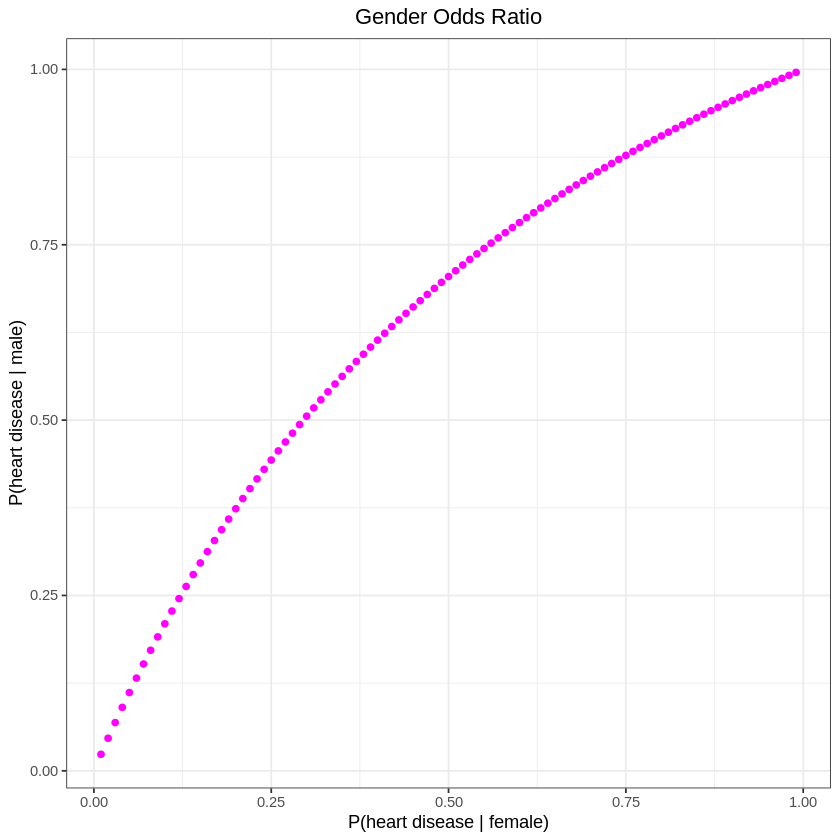

In [ ]:
data <- data.frame(male=male, female=c(1:99) / 100)
 
orPlot <- ggplot(data = data, aes(female, male))
orPlot <- orPlot + geom_point(color="magenta")
orPlot <- orPlot + ylab("P(heart disease | male)")
orPlot <- orPlot + xlab("P(heart disease | female)")
orPlot <- orPlot + ggtitle("Gender Odds Ratio")
orPlot <- orPlot + theme_bw()
orPlot <- orPlot + theme(plot.title = element_text(hjust = 0.5))
orPlot

Based on the result, we can see the odds ratio curve for this variable. It confirms what we said about the odds ratio of having heart disease for male and female. As we see, it is higher for Male.

#### __Part C__
ROC shows the trade off in sensitivity and specificity for 
all possible thresholds.

We can use the area under the curve (AUC) as an 
assessment of the predictive ability of a model.

In [ ]:
predictions <- predict(myModel, type=c("response"))

Setting levels: control = 0, case = 1

Setting direction: controls < cases



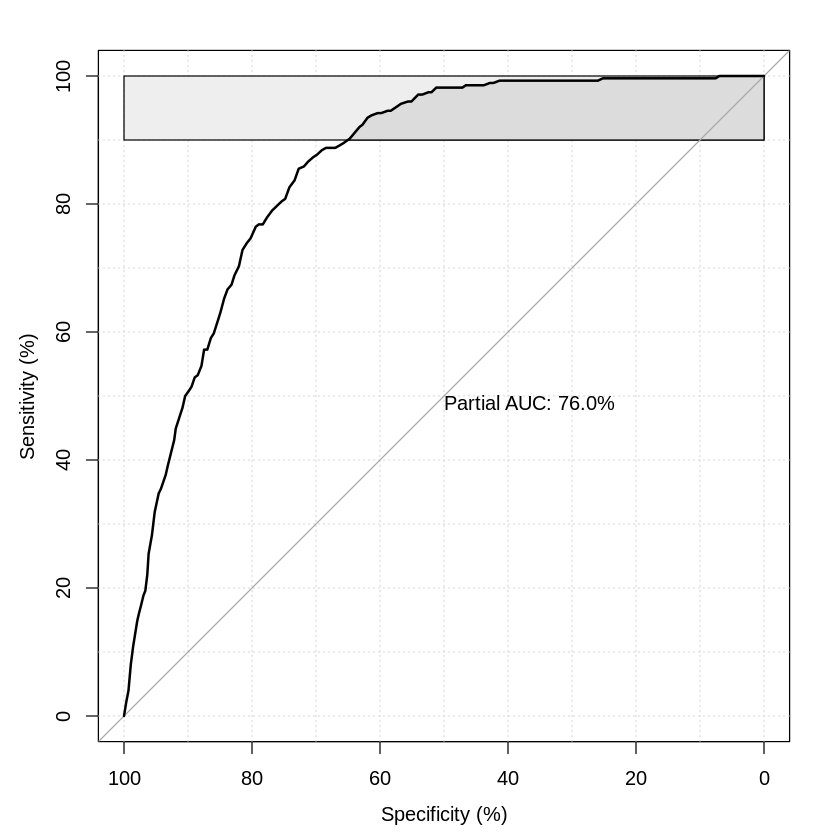

In [ ]:
roc_curve <- roc(heart_disease ~ predictions, data = healthCare, percent=TRUE,  
    partial.auc=c(100, 90),
    partial.auc.correct=TRUE,
    partial.auc.focus="sens",    
    plot=TRUE,
    auc.polygon=TRUE,
    max.auc.polygon=TRUE,
    grid=TRUE,
    print.auc=TRUE,
    show.thres=TRUE)

Based on the result, AUC of our model is 76.09%. As we learnt in class, if it was above 90% we could say that this model is very good at classification, between 90% to 90% is good. But the AUC of our model is below 80% and it is not good.

#### __Part D__

Based on the result, p-value for age is less than p-value for gender. It means that age is more significant predictor than gender. It is undeniable that the older we get, the chance of getting heart disease increases and it is more effective than gender.

#### __Part E__

In [ ]:
fullLogit <- glm(heart_disease ~ . - id, family = binomial, data = healthCare)
summary(fullLogit)


Call:
glm(formula = heart_disease ~ . - id, family = binomial, data = healthCare)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4677  -0.3156  -0.1510  -0.0717   3.4115  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -8.910e+00  1.077e+00  -8.270  < 2e-16 ***
genderMale                  7.981e-01  1.382e-01   5.777 7.62e-09 ***
age                         7.931e-02  5.864e-03  13.524  < 2e-16 ***
hypertensionYes             1.005e-01  1.686e-01   0.596  0.55121    
ever_marriedYes            -3.008e-01  2.206e-01  -1.363  0.17280    
work_typeGovt_job          -2.347e-01  1.094e+00  -0.215  0.83011    
work_typeNever_worked      -9.651e+00  3.051e+02  -0.032  0.97476    
work_typePrivate           -1.834e-01  1.083e+00  -0.169  0.86557    
work_typeSelf-employed     -2.936e-01  1.098e+00  -0.267  0.78915    
Residence_typeUrban        -5.515e-02  1.354e-01  -0.407  0.68373    
avg_glucose_level 

**Step 1**

In [ ]:
step1dropWork <- glm(heart_disease ~ . - id - work_type, family = binomial, data = healthCare)
summary(step1dropWork)


Call:
glm(formula = heart_disease ~ . - id - work_type, family = binomial, 
    data = healthCare)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4491  -0.3164  -0.1518  -0.0708   3.4534  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -9.068e+00  6.045e-01 -15.002  < 2e-16 ***
genderMale                  8.010e-01  1.381e-01   5.801 6.59e-09 ***
age                         7.823e-02  5.453e-03  14.347  < 2e-16 ***
hypertensionYes             9.703e-02  1.683e-01   0.576  0.56434    
ever_marriedYes            -2.996e-01  2.181e-01  -1.374  0.16949    
Residence_typeUrban        -5.411e-02  1.353e-01  -0.400  0.68932    
avg_glucose_level           5.157e-03  1.159e-03   4.451 8.55e-06 ***
bmi                        -1.541e-02  1.190e-02  -1.295  0.19523    
smoking_statusnever smoked -2.032e-01  1.759e-01  -1.155  0.24803    
smoking_statussmokes        5.149e-01  1.995e-01   2.581  0.00985 ** 
s

In [ ]:
step2dropResidence <- glm(heart_disease ~ . - id - work_type - Residence_type, family = binomial, data = healthCare)
summary(step2dropResidence)


Call:
glm(formula = heart_disease ~ . - id - work_type - Residence_type, 
    family = binomial, data = healthCare)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4343  -0.3166  -0.1519  -0.0710   3.4437  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -9.096e+00  6.004e-01 -15.149  < 2e-16 ***
genderMale                  8.020e-01  1.381e-01   5.809 6.29e-09 ***
age                         7.813e-02  5.443e-03  14.353  < 2e-16 ***
hypertensionYes             9.884e-02  1.683e-01   0.587   0.5569    
ever_marriedYes            -2.967e-01  2.180e-01  -1.361   0.1734    
avg_glucose_level           5.153e-03  1.159e-03   4.447 8.71e-06 ***
bmi                        -1.544e-02  1.190e-02  -1.298   0.1944    
smoking_statusnever smoked -2.001e-01  1.757e-01  -1.139   0.2549    
smoking_statussmokes        5.132e-01  1.995e-01   2.573   0.0101 *  
smoking_statusUnknown      -4.304e-02  2.070e-01  -0.2

In [ ]:
step3dropHyper <- glm(heart_disease ~ . - id - work_type - Residence_type - hypertension, family = binomial, 
    data = healthCare)
summary(step3dropHyper)


Call:
glm(formula = heart_disease ~ . - id - work_type - Residence_type - 
    hypertension, family = binomial, data = healthCare)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4524  -0.3186  -0.1527  -0.0709   3.4473  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -9.128e+00  5.984e-01 -15.255  < 2e-16 ***
genderMale                  8.019e-01  1.381e-01   5.808 6.31e-09 ***
age                         7.852e-02  5.404e-03  14.530  < 2e-16 ***
ever_marriedYes            -2.984e-01  2.180e-01  -1.369  0.17097    
avg_glucose_level           5.222e-03  1.152e-03   4.532 5.86e-06 ***
bmi                        -1.504e-02  1.188e-02  -1.265  0.20572    
smoking_statusnever smoked -1.953e-01  1.755e-01  -1.113  0.26584    
smoking_statussmokes        5.140e-01  1.995e-01   2.577  0.00998 ** 
smoking_statusUnknown      -4.989e-02  2.066e-01  -0.241  0.80917    
stroke                     -6.877e-01  

In [ ]:
step4dropBmi <- glm(heart_disease ~ . - id - work_type - Residence_type - hypertension - bmi, family = binomial, 
    data = healthCare)
summary(step4dropBmi)


Call:
glm(formula = heart_disease ~ . - id - work_type - Residence_type - 
    hypertension - bmi, family = binomial, data = healthCare)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4626  -0.3193  -0.1519  -0.0678   3.4891  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -9.5187748  0.5226793 -18.212  < 2e-16 ***
genderMale                  0.8062653  0.1378273   5.850 4.92e-09 ***
age                         0.0797838  0.0053719  14.852  < 2e-16 ***
ever_marriedYes            -0.3078652  0.2174427  -1.416  0.15682    
avg_glucose_level           0.0049528  0.0011299   4.383 1.17e-05 ***
smoking_statusnever smoked -0.1933605  0.1752187  -1.104  0.26979    
smoking_statussmokes        0.5210566  0.1990764   2.617  0.00886 ** 
smoking_statusUnknown      -0.0442510  0.2062031  -0.215  0.83008    
stroke                     -0.6019900  0.2791973  -2.156  0.03107 *  
health_bills                0.000

In [ ]:
step5dropMarried <- glm(heart_disease ~ . - id - work_type - Residence_type - hypertension - bmi - ever_married, 
    family = binomial, data = healthCare)
summary(step5dropMarried)


Call:
glm(formula = heart_disease ~ . - id - work_type - Residence_type - 
    hypertension - bmi - ever_married, family = binomial, data = healthCare)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4644  -0.3240  -0.1530  -0.0623   3.5446  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -9.727e+00  5.096e-01 -19.088  < 2e-16 ***
genderMale                  7.964e-01  1.374e-01   5.797 6.75e-09 ***
age                         7.876e-02  5.391e-03  14.611  < 2e-16 ***
avg_glucose_level           4.853e-03  1.125e-03   4.312 1.61e-05 ***
smoking_statusnever smoked -1.852e-01  1.748e-01  -1.059  0.28943    
smoking_statussmokes        5.230e-01  1.987e-01   2.632  0.00848 ** 
smoking_statusUnknown      -3.463e-02  2.058e-01  -0.168  0.86640    
stroke                     -6.021e-01  2.795e-01  -2.155  0.03120 *  
health_bills                4.072e-04  8.817e-05   4.618 3.87e-06 ***
---
Signif. codes:

In [ ]:
bestGlm <- glm(heart_disease ~ gender + age + avg_glucose_level + health_bills, 
    family = binomial, data = healthCare)
summary(bestGlm)


Call:
glm(formula = heart_disease ~ gender + age + avg_glucose_level + 
    health_bills, family = binomial, data = healthCare)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4524  -0.3220  -0.1580  -0.0712   3.5430  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -9.0617821  0.4049907 -22.375  < 2e-16 ***
genderMale         0.8324774  0.1355936   6.140 8.28e-10 ***
age                0.0744448  0.0051096  14.570  < 2e-16 ***
avg_glucose_level  0.0048683  0.0011180   4.354 1.33e-05 ***
health_bills       0.0002748  0.0000599   4.588 4.47e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2147.7  on 5108  degrees of freedom
Residual deviance: 1621.6  on 5104  degrees of freedom
AIC: 1631.6

Number of Fisher Scoring iterations: 7


#### __Part F__
Our utility function is as follows:

$$utility=TP−FP+TN−4×FN$$

In [ ]:
prob = predict(bestGlm, type=c("response"))

In [ ]:
healthCare$heart <- mapvalues(healthCare$heart_disease,
                           from = c(0, 1),
                           to = c("No", "Yes"))

In [ ]:
utility <- function(thresholds) {
    confusion_matrix = table(healthCare$heart, prob <= thresholds)
    utility = confusion_matrix["Yes", "TRUE"] - confusion_matrix["Yes", "FALSE"] +
            confusion_matrix["No", "TRUE"] -  4 * confusion_matrix["No", "FALSE"]
    return (utility)
}

In [ ]:
thresholds <- matrix(c(1:5109) / 5110, nrow = 1, ncol = 5110)

In [ ]:
utilities = apply(thresholds, 2, utility)

In [ ]:
data <- data.frame(utilities=utilities, thresholds=c(1:99) / 100)
 
ggplot(data = data, aes(thresholds, utilities)) + geom_point()

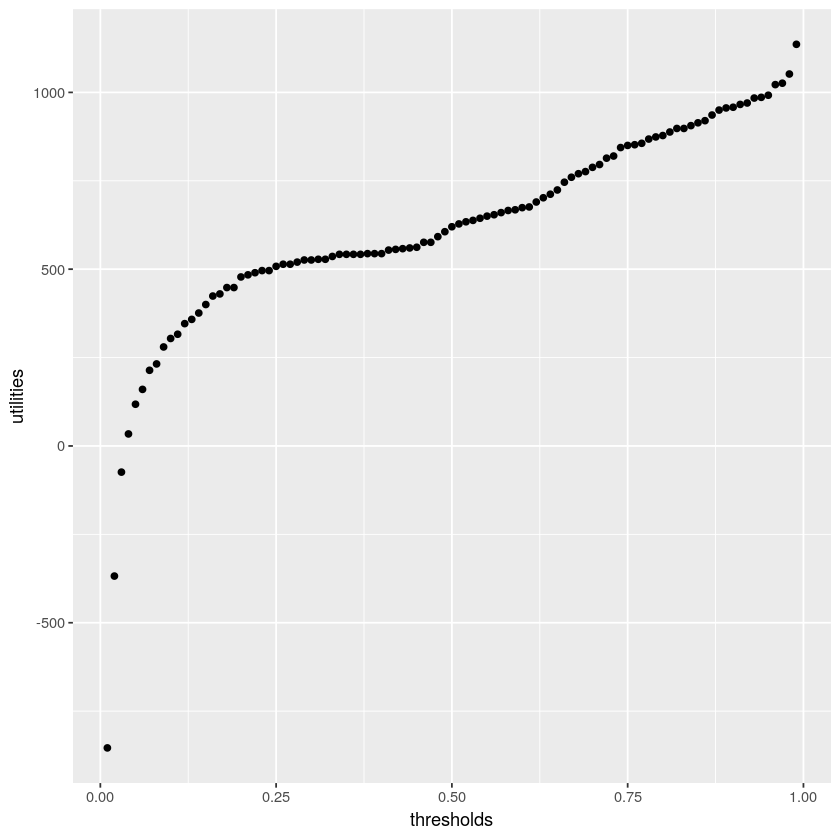

Based on the result,  we can say that about the threshold of  0.24  this curve is broke, so we will choose it as our threshold.

### __Question 7__
At first, we want to choose our threshold for this new variable. We will consider median of *Health Bills*, because this variable is related to high medical costs. Also, we do not consider mean because mean is sensitive to outliers.

In [ ]:
summary(healthCare$health_bills)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   44.8  2647.8  3032.2  3134.6  3454.9  9100.5 

Therefore, our threshold would be 3032.2.

In [ ]:
newHealth <- healthCare
newHealth$high_medical_costs <- healthCare$health_bills > 3032.2

Now, we can see the new column in our data.

In [ ]:
summary(newHealth)

       id           gender               age        hypertension      
 Min.   :   67   Length:5109        Min.   : 0.08   Length:5109       
 1st Qu.:17740   Class :character   1st Qu.:25.00   Class :character  
 Median :36922   Mode  :character   Median :45.00   Mode  :character  
 Mean   :36514                      Mean   :43.23                     
 3rd Qu.:54643                      3rd Qu.:61.00                     
 Max.   :72940                      Max.   :82.00                     
 heart_disease     ever_married        work_type         Residence_type    
 Min.   :0.00000   Length:5109        Length:5109        Length:5109       
 1st Qu.:0.00000   Class :character   Class :character   Class :character  
 Median :0.00000   Mode  :character   Mode  :character   Mode  :character  
 Mean   :0.05402                                                           
 3rd Qu.:0.00000                                                           
 Max.   :1.00000                               

In this part, we create a logistic regression model with all features except *Health Bills*, because we add this new column by that and it can affect our model which is not the goal of question.



In [ ]:
medicalModel <- glm(high_medical_costs ~ .-health_bills - id,family = binomial, data = newHealth)
summary(medicalModel)


Call:
glm(formula = high_medical_costs ~ . - health_bills - id, family = binomial, 
    data = newHealth)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7679  -0.9517   0.0755   1.0119   2.1735  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -4.2537275  0.2079310 -20.457  < 2e-16 ***
genderMale                  0.0910628  0.0654769   1.391   0.1643    
age                         0.0020072  0.0023920   0.839   0.4014    
hypertensionYes             0.2363633  0.1200193   1.969   0.0489 *  
heart_disease               0.2673097  0.1538717   1.737   0.0823 .  
ever_marriedYes            -0.1010322  0.0936619  -1.079   0.2807    
work_typeGovt_job          -0.1432738  0.1694210  -0.846   0.3977    
work_typeNever_worked       0.3203345  0.4839838   0.662   0.5081    
work_typePrivate           -0.0008468  0.1430892  -0.006   0.9953    
work_typeSelf-employed     -0.0333286  0.1723389  -0.193   0.846

Based on the result, bmi has has the most impact on the prediction. Because, it has the lowest p-value among all explanatory variables. But we will perform a backward elimination with p-value to ensure that our answer is correct.

**Step1**

In this step we drop all the levels of work_type, because it has the highest p-value.

In [ ]:
step1dropWorkType <- glm(high_medical_costs ~ .-health_bills - id - work_type, family = binomial, data = newHealth)
summary(step1dropWorkType)


Call:
glm(formula = high_medical_costs ~ . - health_bills - id - work_type, 
    family = binomial, data = newHealth)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7613  -0.9513   0.0763   1.0137   2.1734  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -4.2505429  0.2018691 -21.056  < 2e-16 ***
genderMale                  0.0920392  0.0652716   1.410   0.1585    
age                         0.0016331  0.0021561   0.757   0.4488    
hypertensionYes             0.2382650  0.1196297   1.992   0.0464 *  
heart_disease               0.2730052  0.1536299   1.777   0.0756 .  
ever_marriedYes            -0.1111663  0.0926955  -1.199   0.2304    
Residence_typeUrban        -0.0594561  0.0638747  -0.931   0.3519    
avg_glucose_level           0.0019339  0.0007692   2.514   0.0119 *  
bmi                         0.1406312  0.0058728  23.946  < 2e-16 ***
smoking_statusnever smoked -0.0100991  0.0938636  -0

**Step2**

In this step we drop all the levels of smoking_status, because it has the highest p-value.

In [ ]:
step2dropSmoke <- glm(high_medical_costs ~ .-health_bills - id - work_type - smoking_status, 
    family = binomial, data = newHealth)
summary(step2dropSmoke)


Call:
glm(formula = high_medical_costs ~ . - health_bills - id - work_type - 
    smoking_status, family = binomial, data = newHealth)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7581  -0.9491   0.0775   1.0141   2.1596  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -4.3253011  0.1746554 -24.765  < 2e-16 ***
genderMale           0.0894797  0.0649716   1.377   0.1684    
age                  0.0020234  0.0021115   0.958   0.3379    
hypertensionYes      0.2440560  0.1195460   2.042   0.0412 *  
heart_disease        0.2723423  0.1536648   1.772   0.0763 .  
ever_marriedYes     -0.0999066  0.0924104  -1.081   0.2796    
Residence_typeUrban -0.0578438  0.0638185  -0.906   0.3647    
avg_glucose_level    0.0019300  0.0007693   2.509   0.0121 *  
bmi                  0.1416467  0.0058311  24.292  < 2e-16 ***
stroke               5.4470636  1.0047655   5.421 5.92e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.0

**Step3**

In this step we drop all the levels of Residence_type, because it has the highest p-value.

In [ ]:
step3dropResidence <- glm(high_medical_costs ~ .-health_bills - id - work_type - smoking_status - Residence_type, 
    family = binomial, data = newHealth)
summary(step3dropResidence)


Call:
glm(formula = high_medical_costs ~ . - health_bills - id - work_type - 
    smoking_status - Residence_type, family = binomial, data = newHealth)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7503  -0.9474   0.0764   1.0144   2.1715  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -4.3535894  0.1719809 -25.314  < 2e-16 ***
genderMale         0.0897993  0.0649669   1.382   0.1669    
age                0.0019950  0.0021114   0.945   0.3447    
hypertensionYes    0.2450470  0.1195289   2.050   0.0404 *  
heart_disease      0.2730259  0.1536559   1.777   0.0756 .  
ever_marriedYes   -0.0998645  0.0924064  -1.081   0.2798    
avg_glucose_level  0.0019336  0.0007692   2.514   0.0119 *  
bmi                0.1416368  0.0058316  24.288  < 2e-16 ***
stroke             5.4462686  1.0047789   5.420 5.95e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial famil

**Step4**

In this step we drop age, because it has the highest p-value.

In [ ]:
step4dropAge <- glm(high_medical_costs ~ .-health_bills - id - work_type - smoking_status - Residence_type - age, 
    family = binomial, data = newHealth)
summary(step4dropAge)


Call:
glm(formula = high_medical_costs ~ . - health_bills - id - work_type - 
    smoking_status - Residence_type - age, family = binomial, 
    data = newHealth)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7656  -0.9462   0.0763   1.0160   2.1658  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -4.3372372  0.1710429 -25.358  < 2e-16 ***
genderMale         0.0871303  0.0648912   1.343   0.1794    
hypertensionYes    0.2656335  0.1177090   2.257   0.0240 *  
heart_disease      0.3068456  0.1496034   2.051   0.0403 *  
ever_marriedYes   -0.0459523  0.0725667  -0.633   0.5266    
avg_glucose_level  0.0020127  0.0007648   2.632   0.0085 ** 
bmi                0.1424794  0.0057737  24.677  < 2e-16 ***
stroke             5.4817265  1.0041470   5.459 4.79e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7074.7  on 51

**Step5**

In this step we drop all the levels of ever_married, because it has the highest p-value.

In [ ]:
step5dropMarried <- glm(high_medical_costs ~ gender + hypertension + heart_disease + avg_glucose_level + bmi + stroke, 
    family = binomial, data = newHealth)
summary(step5dropMarried)


Call:
glm(formula = high_medical_costs ~ gender + hypertension + heart_disease + 
    avg_glucose_level + bmi + stroke, family = binomial, data = newHealth)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7622  -0.9468   0.0762   1.0173   2.1712  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -4.3325226  0.1708329 -25.361  < 2e-16 ***
genderMale         0.0886886  0.0648507   1.368  0.17144    
hypertensionYes    0.2576044  0.1169454   2.203  0.02761 *  
heart_disease      0.2984543  0.1489254   2.004  0.04506 *  
avg_glucose_level  0.0019826  0.0007631   2.598  0.00938 ** 
bmi                0.1413567  0.0054847  25.773  < 2e-16 ***
stroke             5.4720879  1.0040051   5.450 5.03e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7074.7  on 5108  degrees of freedom
Residual deviance: 5728.9  on 5102  degrees 

**Step6**

In this step we drop all the levels of gender, because it has the highest p-value.

In [ ]:
step6dropGender <- glm(high_medical_costs ~ hypertension + heart_disease + avg_glucose_level + bmi + stroke, 
    family = binomial, data = newHealth)
summary(step6dropGender)


Call:
glm(formula = high_medical_costs ~ hypertension + heart_disease + 
    avg_glucose_level + bmi + stroke, family = binomial, data = newHealth)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7515  -0.9484   0.0764   1.0197   2.1562  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -4.2985950  0.1689538 -25.442  < 2e-16 ***
hypertensionYes    0.2593195  0.1168976   2.218  0.02653 *  
heart_disease      0.3137647  0.1484217   2.114  0.03451 *  
avg_glucose_level  0.0020211  0.0007625   2.651  0.00804 ** 
bmi                0.1413040  0.0054911  25.733  < 2e-16 ***
stroke             5.4655951  1.0039463   5.444 5.21e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7074.7  on 5108  degrees of freedom
Residual deviance: 5730.8  on 5103  degrees of freedom
AIC: 5742.8

Number of Fisher Scoring iterations: 8


As we can see, all the predictors are significant. But, bmi has the lowest p-value among them. So it is the best predictor for it. 

As what we saw in previous parts, bmi was the most correlated variable with health bills. Moreover, we built this new feature from health bills. So, we can conclude that bmi would be the best predictor for it.